# `Optuna` optimization analysis - D1_20241109_114242

Nota: la prima cosa che si osserva dal post-processing è che il DRAG ha fallito, anche questo può aver influito sulla ottimizzazione con `optuna`.

Le RB per cui l'incertezza sulla fidelity è di molto superiore all'unità sono RB in cui per qualche motivo il fit non funziona (presumibilmente i parametri scelti non sono adatti.)

In [1]:
import optuna
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_edf,
    plot_parallel_coordinate,
    plot_slice,
    plot_contour
)
import matplotlib.pyplot as plt
from pathlib import Path


/home/elisa/calibration/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
WIDTH  = 0.5
FONT = 24

BLUE = "#788ae3"
RED = "#d1545e"
DARKBLUE = "#075cb3"
DARKRED = "#8c1822"

### Load study from database

In [9]:
target = "D1"
study_name = "20241121_192626"
path = f"../../optuna_data/{target}_{study_name}.db"

# Construct SQLAlchemy URL
db_path = f"sqlite:///{path}"
print(db_path)

study = optuna.load_study(study_name=study_name, storage=db_path)

sqlite:///../../optuna_data/D1_20241121_192626.db


## Objeptimization analysis with optuna tools

In [10]:
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_parallel_coordinate(study).show()

In [11]:
optuna.visualization.plot_param_importances(study).show()

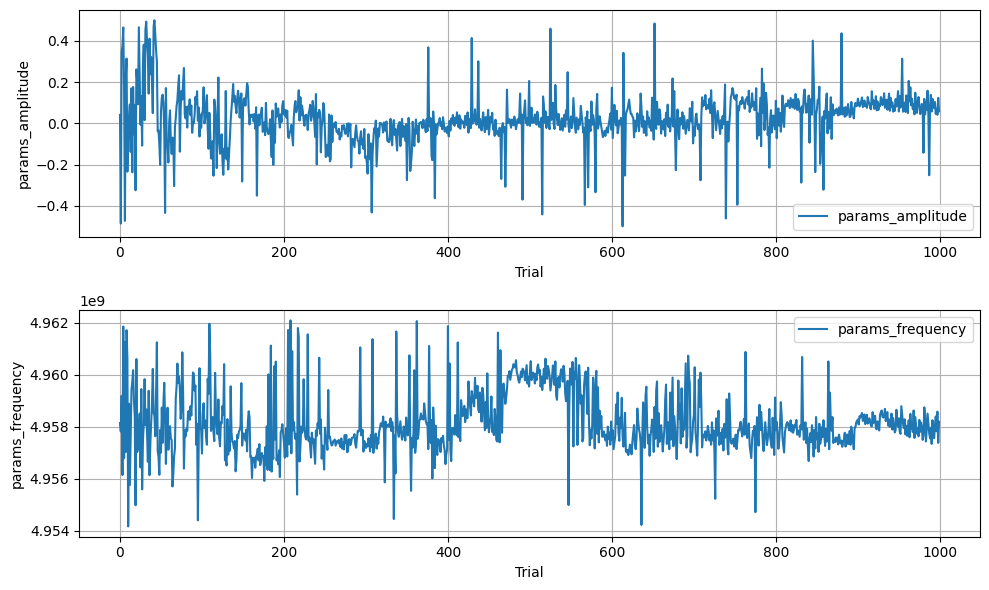

In [12]:
# Get all trials and plot parameter histories individually
trials = study.trials_dataframe()

# Separate plots for each parameter
params_columns = [col for col in trials.columns if col.startswith("params_")]

fig, axes = plt.subplots(len(params_columns), 1, figsize=(10, len(params_columns) * 3))

for i, param in enumerate(params_columns):
    ax = axes[i]
    ax.plot(trials["number"], trials[param], label=param)
    ax.set_xlabel("Trial")
    ax.set_ylabel(param)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


## Optimization analysis

In [13]:
df = study.trials_dataframe()

#NB: objective value is RB infidelity
objective_values = df['value'].to_numpy()
objective_error = df['user_attrs_error'].to_numpy()
iterations = df['number']

#build params dictionary
params = {par: df[par].dropna().to_numpy() for par in params_columns}
print(params)

{'params_amplitude': array([ 4.07700000e-02, -4.85249705e-01,  3.43964797e-01,  3.76791155e-01,
        4.64480168e-01,  1.75448782e-01, -4.72618702e-01,  2.11513471e-01,
        3.13838023e-01, -2.34096153e-01, -5.31292894e-02,  3.33050045e-02,
        9.15721755e-02, -1.38339526e-01,  1.69554752e-01, -2.37203756e-01,
        1.76143954e-01, -5.32828515e-02,  8.95198716e-02, -3.24366095e-01,
        2.61146996e-01,  2.02957577e-01,  9.21034765e-02,  4.65357835e-01,
        2.36733244e-01, -6.32932166e-03,  1.31272096e-01, -1.07836486e-01,
        2.82844065e-01,  3.80948047e-01,  1.56023256e-02,  4.52379189e-01,
        4.92416200e-01,  3.93638923e-01,  3.29446126e-01,  1.43783080e-01,
        4.09599349e-01,  2.37962760e-01,  3.21386495e-01,  2.01274711e-01,
        4.96148931e-02,  4.69497890e-01,  4.99068210e-01,  4.32322782e-01,
        3.53933899e-01,  2.99552959e-01, -3.89161948e-02, -3.41781269e-02,
       -1.02990718e-01, -2.01201698e-01,  5.61976857e-02,  1.24846129e-01,
    

/tmp/ipykernel_47121/806558833.py:8: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



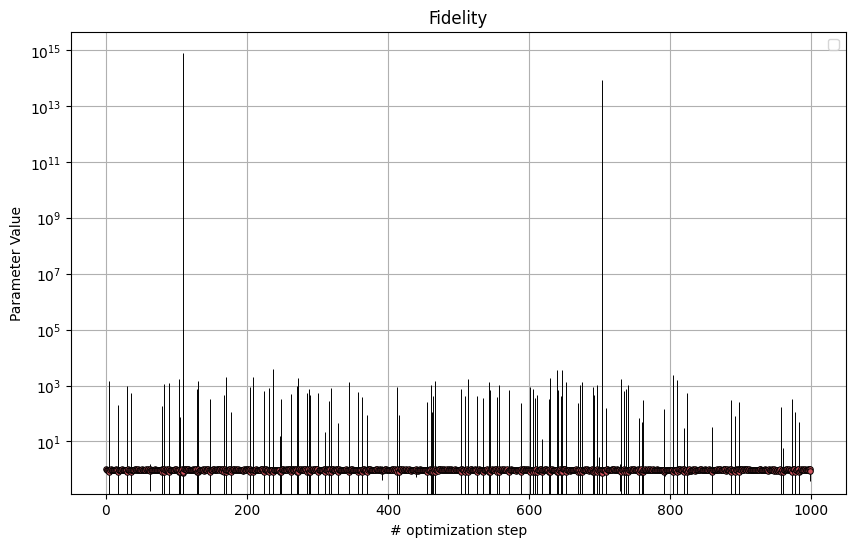

In [14]:
plt.figure(figsize=(10, 6))
plt.errorbar(iterations, 1-objective_values, yerr=objective_error, fmt = 'o', markersize=4, color='black', linestyle='-',
         markerfacecolor=RED, markeredgewidth=0.7, linewidth=0.7, alpha=1)
plt.xlabel('# optimization step')
plt.ylabel('Parameter Value')
plt.yscale('log')
plt.title(f'Fidelity')
plt.legend()
plt.grid()
plt.show()

In [15]:
for i in range(len(objective_values)):
    if 1-objective_values[i] + objective_error[i] > 1:
        print(i)

5
17
30
35
63
80
82
90
103
105
109
110
111
129
130
137
148
168
170
178
194
204
208
224
231
237
247
248
262
271
273
285
288
289
301
310
316
319
329
344
357
362
363
370
391
413
415
416
433
439
442
456
461
463
464
466
504
509
514
526
531
535
543
545
555
557
570
572
589
602
606
609
611
618
628
630
640
641
646
647
653
658
669
672
675
685
691
692
694
697
699
704
709
729
731
734
738
741
745
756
760
761
791
793
804
810
819
824
860
887
892
897
948
957
960
973
977
983
999


/tmp/ipykernel_47121/3497117488.py:8: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



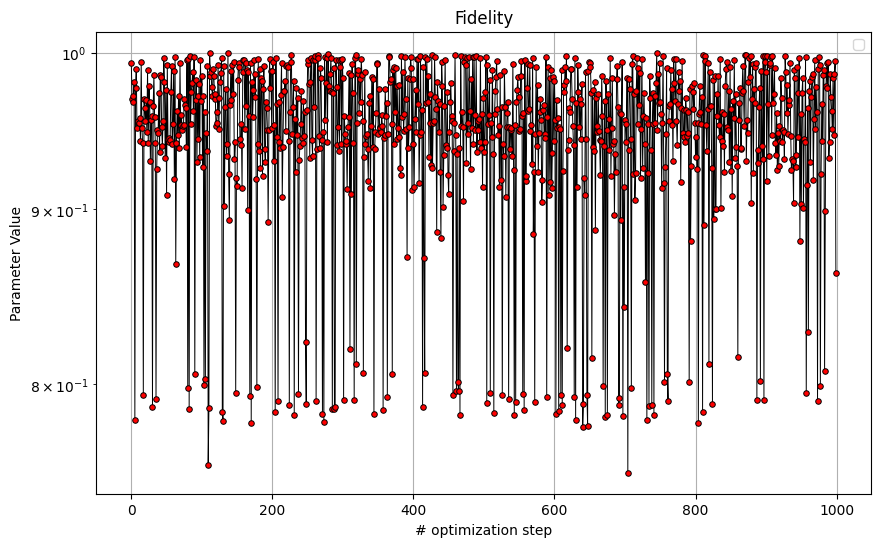

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(iterations, 1 - objective_values, 'o-', markersize=4, color='black', 
         markerfacecolor='red', markeredgewidth=0.7, linewidth=0.7, alpha=1)
plt.xlabel('# optimization step')
plt.ylabel('Parameter Value')
plt.yscale('log')
plt.title(f'Fidelity')
plt.legend()
plt.grid()
plt.show()

In [17]:
best_trial = study.best_trial

print("Best trial:")
print(f"  Trial number: {best_trial.number}")
print(f"  Value (Objective): {best_trial.value}")
print("  Parameters:")

for param_name, param_value in best_trial.params.items():
    print(f"    {param_name}: {param_value}")

print(f"fidelity: {1-best_trial.value}")

Best trial:
  Trial number: 137
  Value (Objective): -5.707417797632767e-08
  Parameters:
    amplitude: 0.12712736547419862
    frequency: 4957424456.398733
fidelity: 1.000000057074178


## Inspectring database structure

In [18]:
print("Columns in Optuna study trials DataFrame")
print(df.info())
print(df.head())

Columns in Optuna study trials DataFrame
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   number                     1000 non-null   int64          
 1   value                      1000 non-null   float64        
 2   datetime_start             1000 non-null   datetime64[ns] 
 3   datetime_complete          1000 non-null   datetime64[ns] 
 4   duration                   1000 non-null   timedelta64[ns]
 5   params_amplitude           1000 non-null   float64        
 6   params_frequency           1000 non-null   float64        
 7   user_attrs_error           1000 non-null   float64        
 8   system_attrs_fixed_params  1 non-null      object         
 9   state                      1000 non-null   object         
dtypes: datetime64[ns](2), float64(4), int64(1), object(2), timedelta64[ns](1)
memory